# Supervised classification using Sentinel-2 data

This project introduces an example of a supervised land cover classification with Sentinel-2 data. The aim is to classify a Sentinel-2 image into four different land cover classes: `water surfaces`, `artificial surfaces`, `low vegetation` and `tree cover`.

# Data

This project shows the process to classify a pre-processed Sentinel-2 image subset. The following operations were conducted in before-hand on the original Sentinel-2 image file:
* `Subsetting` to a dimension of `(200, 600)` pixels
* `Resampling` of all 13 bands to a 10 m resolution, and
* `Saving` the 13 bands as individual `.tif` files

Additionally, a set of training and validation data points have been manually identified:
* `training data`: four .txt files containing 100 labelled training point locations (X and Y) for each of the land cover classes ([artifical surfaces](./training_data/artificial_surfaces.txt), [low vegetation](./training_data/low_vegetation.txt), [tree cover](./training_data/tree_cover.txt), [water](./training_data/water.txt))
* `validation data`: a [.txt file](./validation_data/validation_points.txt) containing 100 labelled training point locations together with the respective land cover class

#### Import libraries

In [62]:

import numpy as np

from skimage import io
from skimage import exposure
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

#### Helper function

In [63]:
def composition(band1,band2,band3):
    im_comp=np.dstack([band1/band1.max(), band2/band2.max(), band3/band3.max()])
    for i in range(3):
        v_min, v_max = np.percentile(im_comp[:,:,i],(1,98))
        im_comp[:,:,i] = exposure.rescale_intensity(im_comp[:,:,i],in_range=(v_min,v_max))
    return im_comp

## <a id='load_s2_image_3d2'></a>Load and display a Sentinel-2 image


In [83]:
imFolder = './S2_data/'
coll = io.ImageCollection(imFolder + '*.tif')

# a list of loaded files
print(coll.files)

band_names=['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']

['./S2_data\\B1.tif', './S2_data\\B2.tif', './S2_data\\B3.tif', './S2_data\\B4.tif', './S2_data\\B5.tif', './S2_data\\B6.tif', './S2_data\\B7.tif', './S2_data\\B8a.tif', './S2_data\\B9.tif', './S2_data\\B10.tif', './S2_data\\B11.tif', './S2_data\\B12.tif']


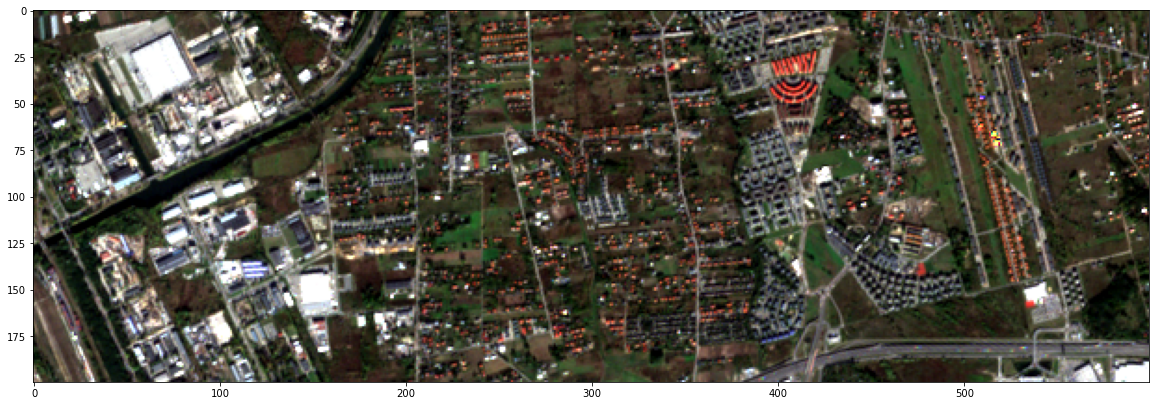

In [84]:
im_comp = composition(coll[3],coll[2],coll[1])
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

## <a id='load_training_point_3d2'></a>Load and display training point locations

In [86]:
p_water = np.loadtxt('./training_data/water.txt',dtype='int')
p_artificial = np.loadtxt('./training_data/artificial_surfaces.txt',dtype='int')
p_low_veg = np.loadtxt('./training_data/low_vegetation.txt',dtype='int')
p_trees = np.loadtxt('./training_data/tree_cover.txt',dtype='int')

LC_class_names = ['water', 'artificial', 'low vegetation', 'tree cover']

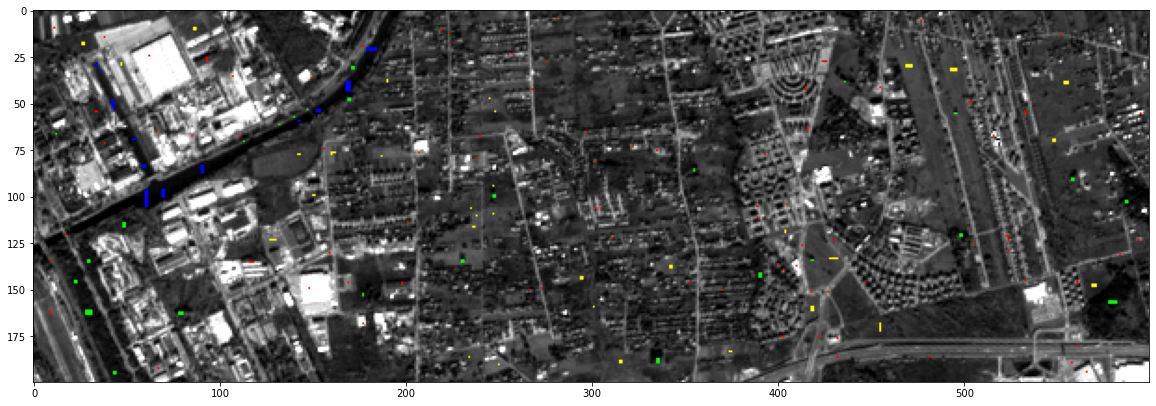

In [87]:
im_comp_p=np.zeros(im_comp.shape)
im_comp_p[:,:,0]=rgb2gray(im_comp)
im_comp_p[:,:,1]=rgb2gray(im_comp)
im_comp_p[:,:,2]=rgb2gray(im_comp)

# marking in blue the training points for 'water' class
im_comp_p[p_water[:,0],p_water[:,1],0] =0
im_comp_p[p_water[:,0],p_water[:,1],1] =0
im_comp_p[p_water[:,0],p_water[:,1],2] =1

# marking in red the training points for 'artificial surfaces' class
im_comp_p[p_artificial[:,0],p_artificial[:,1],0] =1
im_comp_p[p_artificial[:,0],p_artificial[:,1],1] =0
im_comp_p[p_artificial[:,0],p_artificial[:,1],2] =0

# marking in yellow the training points for 'low vegetation' class
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],0] =1
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],1] =1
im_comp_p[p_low_veg[:,0],p_low_veg[:,1],2] =0

# marking in green the training points for 'tree cover' class
im_comp_p[p_trees[:,0],p_trees[:,1],0] =0
im_comp_p[p_trees[:,0],p_trees[:,1],1] =1
im_comp_p[p_trees[:,0],p_trees[:,1],2] =0

plt.figure(figsize=(20,10))
plt.imshow(im_comp_p)

## <a id='data_transformation_3d2'></a>Data transformation for supervised classification

The first step is to retrieve the information of the 13 Sentinel-2 image bands for the 100 training points for the land cover class 1 - water. For each band, the information of the 100 pixels is retrieved and the information is appended to the final bands list.

In [88]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_water[:,0],p_water[:,1]]
    bands.append(band)

As a next step, you want to convert the list `bands` into a `numpy.ndarray`. You can convert a list into a multidimensional array with the function `np.stack()`. The resulting array needs to be transposed in order to have the 100 training points as rows and the 13 bands information as columns.

In [89]:
X_water=np.stack(bands).T
X_water.shape

(100, 12)

The same steps as above need to be repeated for each of the land cover classes. Thus, the next step is to retrieve the band information for the training pixels of the land cover class `2 - artificial surface`.

In [90]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_artificial[:,0],p_artificial[:,1]]
    bands.append(band)

X_artificial=np.stack(bands).T
X_artificial.shape

(100, 12)

The next step is to repeat the same steps as above also for the land cover class `3 - low vegetation`.

In [71]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_low_veg[:,0],p_low_veg[:,1]]
    bands.append(band)
    
# step 2 - stacking band vectors into a table    
X_low_veg=np.stack(bands).T
X_low_veg.shape

(100, 12)

And, last but not least, we repeat the same steps as above as well for the land cover class `4 - tree cover`.

In [72]:
bands=[]
for i in range(len(coll)):
    band = np.asarray(coll[i].data)[p_trees[:,0],p_trees[:,1]]
    bands.append(band)
    
X_trees=np.stack(bands).T
X_trees.shape

(100, 12)

For the final input data array (`X`), we combine the four data arrays into one, by concatenating the arrays by rows. The dimension of the final data array has 400 rows, which reflects the 400 training pixels for each land cover class and 13 columns, reflecting the Sentinel-2 band information for each training point.

In [73]:
# stacking data for all classes in one table
X=np.vstack((X_water,X_artificial,X_low_veg,X_trees))

X.shape

(400, 12)

As output data (`y`), we create an array with the respective land cover class of each training point. The final dimension of the output array is `(400, 1)`.

In [74]:
y=np.vstack((np.ones((X_water.shape[0], 1)),
             2*np.ones((X_artificial.shape[0], 1)),
             3*np.ones((X_low_veg.shape[0], 1)),
             4*np.ones((X_trees.shape[0], 1))))

y.shape

(400, 1)

Subsequently, we will define and train the following a decision tree classifier: `Decision Tree`,

In [75]:
dt_clf = DecisionTreeClassifier(max_depth = 10) 

dt_clf.fit(X, np.ravel(y))

DecisionTreeClassifier(max_depth=10)

You can use the function `plot_tree()` to visualize the trained decision tree. You can specify the following keyword arguments:
* `feature_names` - `band names` and 
* `class_names` - `land cover class names` 

**Note:** you can double-click on the resulting image in order to zoom in.

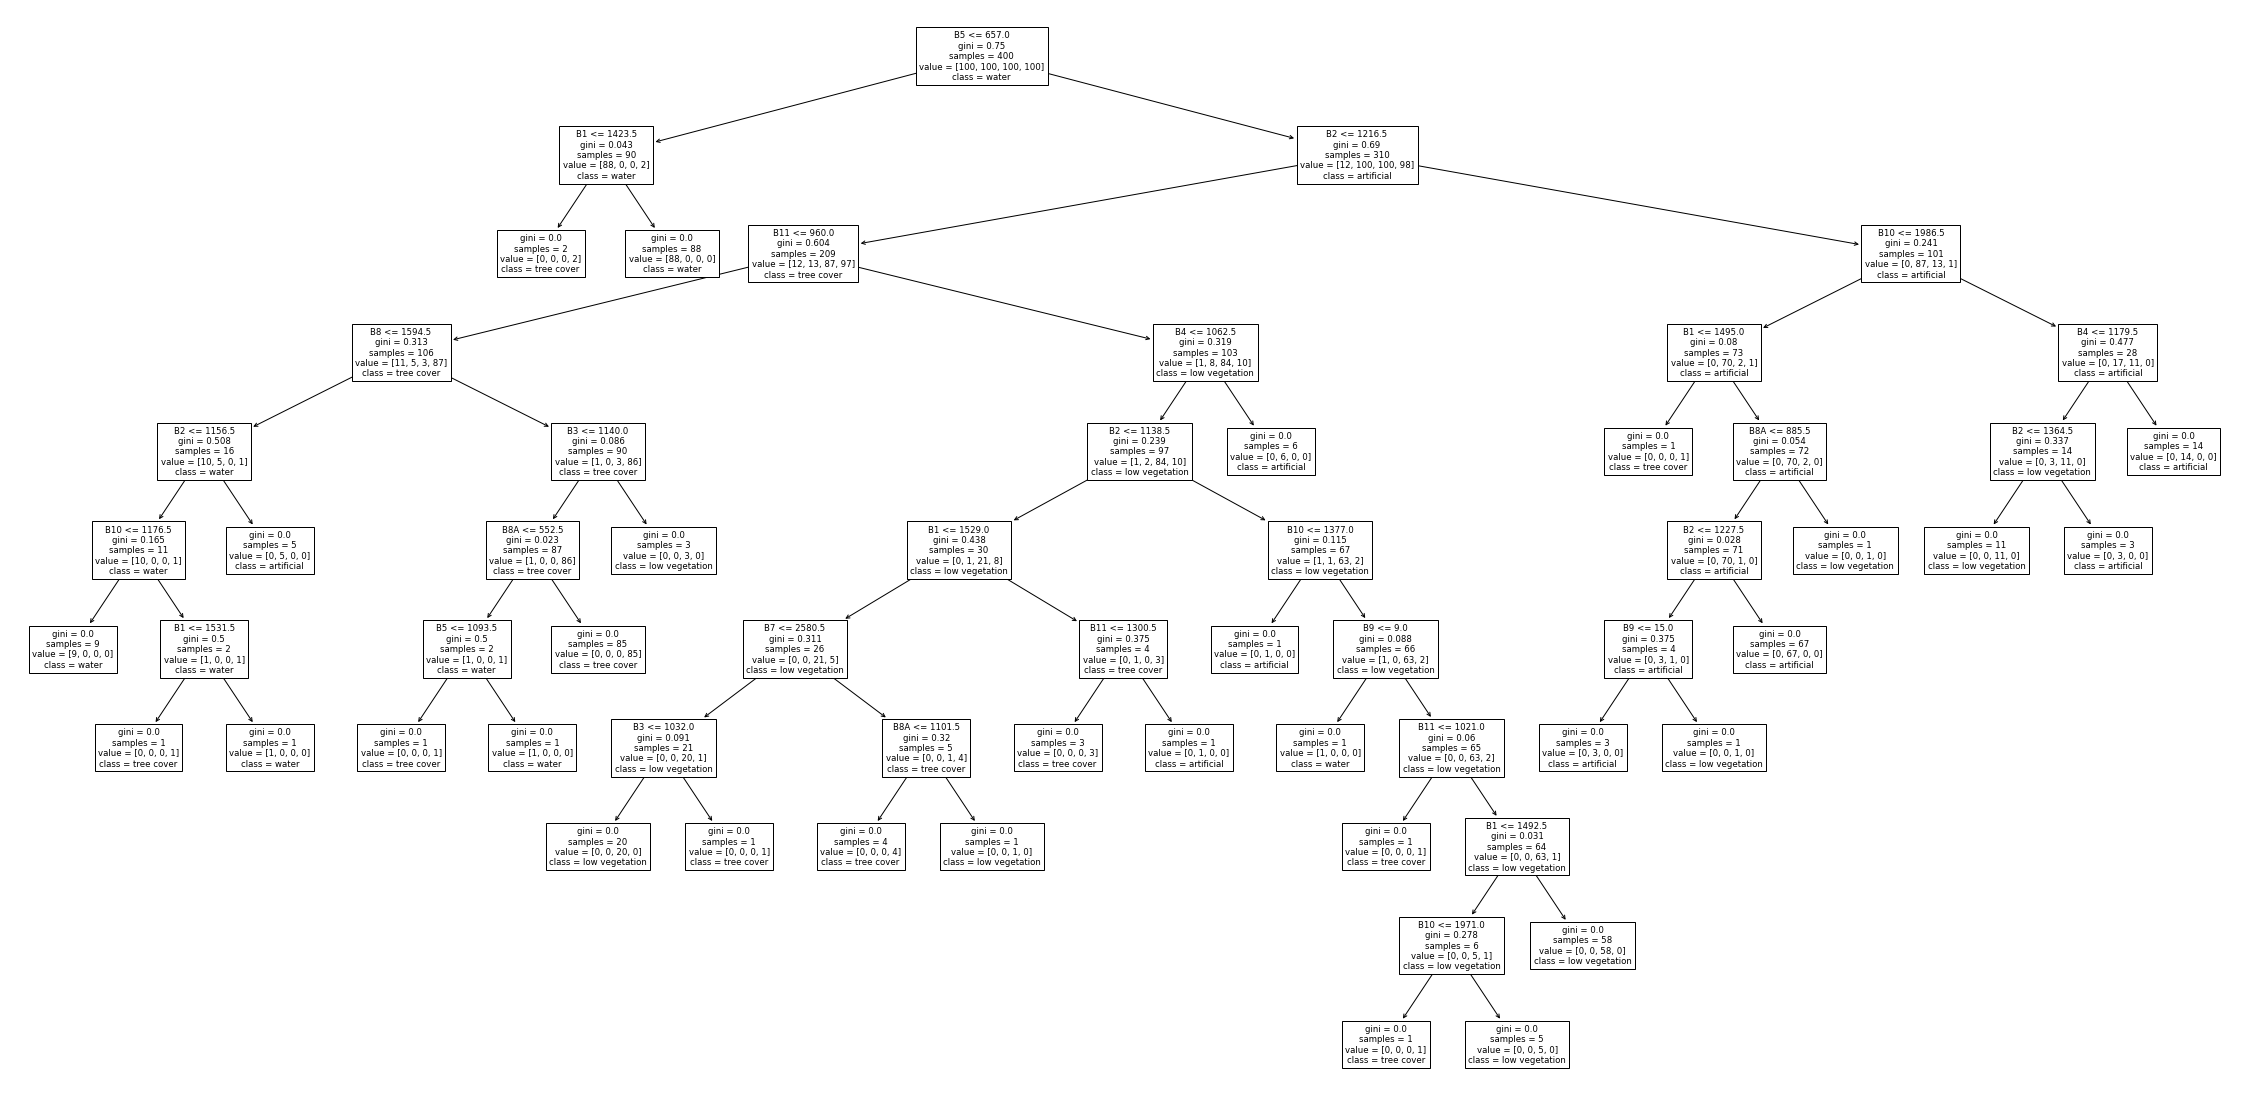

In [76]:
fig = plt.figure(figsize=(40,20))
plot_tree(dt_clf, 
          feature_names = band_names, 
          class_names = LC_class_names ) 
plt.show()

### Load the model

In [77]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(dt_clf, open(filename, 'wb'))

### 5.1 Prediction with the trained DecisionTree model

With the function `predict()`, you can use the trained DecisionTree `dt_clf` and classify the Sentinel-2 image into the four land cover classes. The resulting array `Y_pred_dt` has a shape of 120,000 rows, containing the predicted land cover class for each pixel of the flattend Sentinel-2 image.

In [78]:
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
Y_pred_dt = loaded_model.predict(X_all)
Y_pred_dt.shape

(120000,)

As a next step, you can visualize the classified image. For this, you will need to reshape the array `Y_pred_dt` into the shape of the original Sentinel-2 image, `(200, 600)`. You can use the function `reshape()` to do so.

In [79]:
Y_im_dt = Y_pred_dt.reshape(coll[1].shape)
Y_im_dt.shape

(200, 600)

Text(340, 6, 'Tree cover')

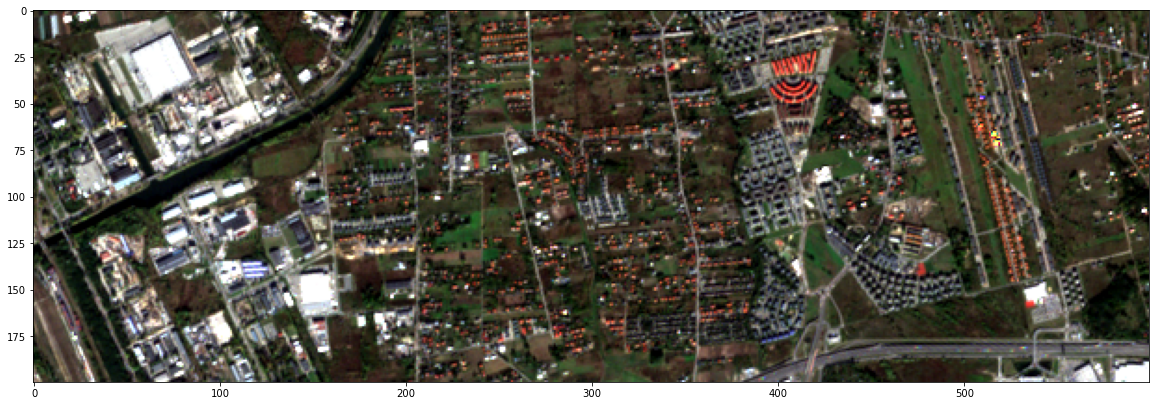

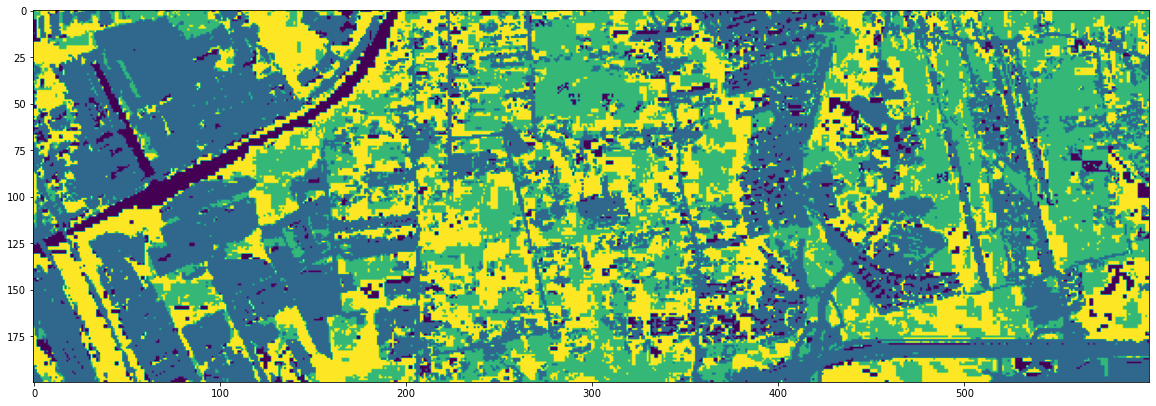

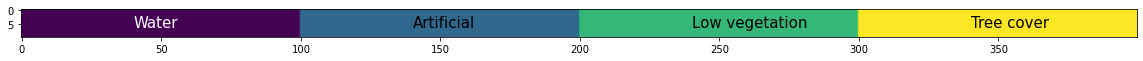

In [80]:
# Plot the original image
plt.figure(figsize=(20,10))
plt.imshow(im_comp)

# Plot the classified image
plt.figure(figsize=(20,10))
plt.imshow(Y_im_dt)

# Plot the legend
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Water', fontsize=15,  color='white')
ax.text(140, 6, 'Artificial', fontsize=15,  color='black')
ax.text(240, 6, 'Low vegetation', fontsize=15,  color='black')
ax.text(340, 6, 'Tree cover', fontsize=15,  color='black')